In [1]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch

from transformers import SamModel, SamProcessor
from diffusers import AutoPipelineForInpainting
from diffusers.utils import make_image_grid

from sam_inpainting_utils import get_processed_inputs, mask_to_rgb, inpaint
import app_new

## Download Models

In [2]:
sam_model_name = "facebook/sam-vit-base"
diffusion_model_name = "diffusers/stable-diffusion-xl-1.0-inpainting-0.1"


device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained(sam_model_name).to(device)
processor = SamProcessor.from_pretrained(sam_model_name)

pipeline = AutoPipelineForInpainting.from_pretrained(diffusion_model_name, torch_dtype=torch.float16)
# This will make it more efficient on our hardware
pipeline.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


## Test Inpainting Pipeline

### Get Mask using SAM

Prediction masks shape: torch.Size([1, 1, 3, 256, 256])
Original sizes shape: torch.Size([1, 2])
Reshaped input sizes shape: torch.Size([1, 2])
Inverted best mask shape: (512, 512)


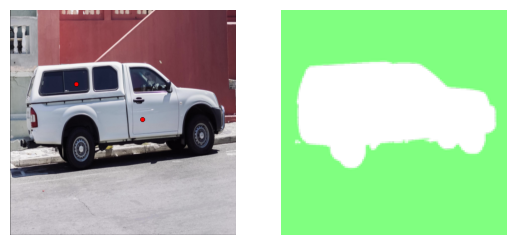

In [5]:
image_path = "images/car.png"


# open the image and resize it to 512x512 pixels
raw_image = Image.open(image_path)
res_raw_image = raw_image.convert("RGB").resize((512, 512))

# define a few points on the image (that indicate where the car is)
input_points = [[[150, 170], [300, 250]]]

# Create a drawing object
image_with_stars = res_raw_image.copy()
draw = ImageDraw.Draw(image_with_stars)

# Draw each point on the image
for point in input_points[0]:
    x, y = point
    radius = 5  # Marker size
    vertices = (x - radius, y - radius, x + radius, y + radius)
    draw.ellipse(vertices, fill="red", outline="black")


# generate a mask using SAM
mask = get_processed_inputs(processor, model, res_raw_image, input_points, device, verbose=True)
# visualize the mask
mask_image = Image.fromarray(mask_to_rgb(mask))
res_mask_image = mask_image.resize((128, 128))


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.imshow(image_with_stars)
ax2.imshow(res_mask_image)
ax1.axis('off')
ax2.axis('off')
plt.show()

### Inpainting

  0%|          | 0/49 [00:00<?, ?it/s]

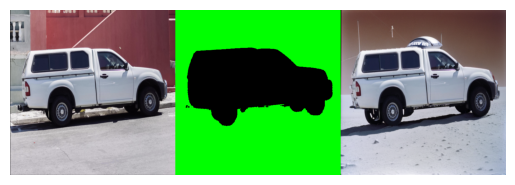

In [8]:
prompt = "a car driving on Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"
cfgs = 7.0
seed = 74294536


inpainted_image = inpaint(pipeline, res_raw_image, mask, prompt, negative_prompt, cfgs, seed)
res_inpainted_image = inpainted_image.resize((512, 512))
fig = make_image_grid([res_raw_image, mask_image, res_inpainted_image], rows=1, cols=3)

plt.imshow(fig)
plt.axis("off")
plt.show()

## Interactive App

In [ ]:
my_app = app_new.generate_app(get_processed_inputs, inpaint)

In [ ]:
my_app.close()